In [2]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

from akita_utils import *
import pysam
import h5py
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [188]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.6.2
built
restored


(512, 130305, (130305,))

In [3]:
akita_XL_dir = '/project/fudenber_735/tensorflow_models/akita/v2/analysis/'
df_model1_perm = h5_to_df(akita_XL_dir+'permute_boundaries_motifs_ctcf_mm10_model1/scd.h5')
df_model7_perm = h5_to_df(akita_XL_dir+'permute_boundaries_motifs_ctcf_mm10_model7/scd.h5')
df = df_model1_perm.copy()
df['SCD'] = .5* (df_model1_perm['SCD'].values+df_model7_perm['SCD'].values)
df['INS-64'] = .5* (df_model1_perm['INS-64'].values+df_model7_perm['INS-64'].values)
df['span'] = df['span'].str.decode('utf8')
df.shape

orig 26544 filt 26515
29 duplicates removed
orig 26544 filt 26515
29 duplicates removed


(26515, 28)

In [4]:
## append scores for full mut and all ctcf mut to table
score_10k = np.zeros((len(df),))
score_all_ctcf = np.zeros((len(df),))
for i in np.unique(df['boundary_index'].values):
    if np.mod(i,1000)==0: print(i)
    inds = df['boundary_index'].values== i 
    df_boundary = df.iloc[inds]
    score_10k[inds] = df_boundary.iloc[-1]['SCD']
    if len(df_boundary)> 2:
        score_all_ctcf[inds] = df_boundary.iloc[-2]['SCD']
df['score_all_ctcf']= score_all_ctcf
df['score_10k']= score_10k


0
1000
2000
3000
4000


In [5]:
# considering only single ctcf mutations 
# require that they fall in an overall boundary that has some saliency
# TODO: also require that the neighboring bins don't have a more salient boundary?
# suffix _2 means _motif
sites = df.iloc[ (df['strand_2'].values != 'nan') *
                 (df['score_all_ctcf'].values > 5)
                ].copy()

# extracting start/end of motif from span
sites  = pd.concat([
                sites, 
                sites['span'].str.split('-', expand=True).astype(int).rename(columns={0:'start_2',1:'end_2'}).copy()],axis=1)
sites.reset_index(inplace=True,drop=True)

In [6]:
# require that sites don't overlap rmsk !
# this is important for sineB2 in mice, maybe other things as well

rmsk_cols = pd.read_csv(StringIO('bin	swScore	milliDiv	milliDel	milliIns	genoName	genoStart	genoEnd	genoLeft	strand	repName	repClass	repFamily	repStart	repEnd	repLeft	id'),sep= '\t')
rmsk = pd.read_table('/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz', names=rmsk_cols.keys())
rmsk.rename(columns={'genoName':'chrom','genoStart':'start','genoEnd':'end'}, inplace=True)
                     
sites = bioframe.count_overlaps(
                    sites, 
                    rmsk[['chrom','start','end']], cols1=['chrom','start_2','end_2'])
sites = sites.iloc[sites['count'].values==0]
sites.reset_index(inplace=True,drop=True)
if sites.duplicated().sum() > 0: 
    raise ValueError("no duplicates allowed")
    
sites['count'].sum(), (sites['count']==0).sum(), len(df), len(sites)

(0, 4414, 26515, 4414)

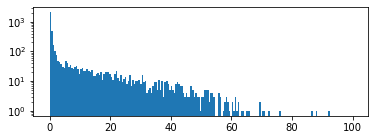

In [7]:
plt.figure(figsize=(6,2))
plt.hist(sites['SCD'].values, np.linspace(-.5,100,200)  );
plt.semilogy();

In [8]:
weak_thresh_pct = 1 # don't use sites weaker than this, might be artifacts
weak_num = 500 
strong_thresh_pct = 99 # don't use sites weaker than this, might be artifacts
strong_num = 500 

value_key = 'SCD'
strong_thresh = np.percentile(sites[value_key].values,strong_thresh_pct)
weak_thresh = np.percentile(sites[value_key].values,weak_thresh_pct)

weak_sites   = sites.loc[ sites[value_key] > weak_thresh  ].copy().sort_values(value_key)[:weak_num]
strong_sites = sites.loc[ sites[value_key] < strong_thresh  ].copy().sort_values(value_key)[-strong_num:][::-1]

In [9]:
weak_sites.reset_index(inplace=True,drop=True)
strong_sites.reset_index(inplace=True,drop=True)

In [ ]:
max_iters = 1
batch_size = 6
shuffle_k = 8

## alternate approach, figure out a way to nicely use the whole JASPAR motif
# motif_file = '/project/fudenber_735/motifs/pfms/JASPAR2022_CORE_redundant_pfms_jaspar/MA0139.1.jaspar'
# motif = read_jaspar_to_numpy(motif_file)
### using just the core motif and this shuffling which also makes the reverse complement a low score works well
mot = '>CCAsyAGrkGGCr\n0.0000\t1.0000\t0.0000\t0.0000\n0.0000\t1.0000\t0.0000\t0.0000\n1.0000\t0.0000\t0.0000\t0.0000\n0.0000\t0.5000\t0.5000\t0.0000\n0.0000\t0.5000\t0.0000\t0.5000\n1.0000\t0.0000\t0.0000\t0.0000\n0.0000\t0.0000\t1.0000\t0.0000\n0.5000\t0.0000\t0.5000\t0.0000\n0.0000\t0.0000\t0.5000\t0.5000\n0.0000\t0.0000\t1.0000\t0.0000\n0.0000\t0.0000\t1.0000\t0.0000\n0.0000\t1.0000\t0.0000\t0.0000\n0.5000\t0.0000\t0.5000\t0.0000'
motif = pd.read_csv(StringIO(mot),sep='\t',header=0, names=['A','C','G','T']).values
motif_window = int(np.ceil(len(motif)/2))
mot_shuf = np.array([12,0,1,11,10,3,2,8,9,4,5,7,6]) 

ctcf_thresh = 8
scores_thresh = 5500
scores_pixelwise_thresh = .04

site_df =  pd.concat([strong_sites[:5].copy(),weak_sites[:5].copy()])
num_seqs = site_df.shape[0]

flat_seqs = []
for ind in range(num_seqs):
    print(ind)
    chrom, start, end, strand = site_df.iloc[ind][['chrom','start_2','end_2','strand_2']]
    mid = int(.5 * (start +end))
    start, end =  mid - seq_length//2 , mid + seq_length//2
    seq = genome_open.fetch(chrom, start, end).upper()
    #if strand == '-': seq = dna_rc(seq)
    seq_1hot = dna_io.dna_1hot(seq)

    num_iters = 0
    while num_iters < max_iters:
        print('ind',ind, ', iter ',num_iters,', for', chrom, start, end)
        print(len(flat_seqs))
        
        seq_1hot_batch = []
        for i in range(batch_size):
            seq_1hot_mut = permute_seq_k(seq_1hot,k= shuffle_k)
            s = scan_motif(seq_1hot_mut, motif  )
            for i in np.where(s > ctcf_thresh)[0]:
                #seq_1hot_mut[i-motif_window:i+motif_window] = permute_seq_k(seq_1hot_mut[i-motif_window:i+motif_window], k=2)
                seq_1hot_mut[i-motif_window+1:i+motif_window] = seq_1hot_mut[i-motif_window+1:i+motif_window][mot_shuf]
            seq_1hot_batch.append(seq_1hot_mut)
        seq_1hot_batch = np.array(seq_1hot_batch)

        pred = seqnn_model.predict(seq_1hot_batch, batch_size=batch_size)
        scores = np.sum( pred**2, axis=-1).sum(axis=-1)
        scores_pixelwise = np.max(pred**2, axis=-1).max(axis=-1)

        if np.any( (np.min(scores) < scores_thresh) * (np.min(scores_pixelwise) < scores_pixelwise_thresh)):
            best_ind = np.argmin(scores_pixelwise)
            best_seq = seq_1hot_batch[best_ind]
            best_pred = pred[best_ind]
            best_score, best_score_pixelwise = scores[best_ind] , scores_pixelwise[best_ind]
            num_iters = max_iters
            print('success: best seq, thresh', np.min(scores),' pixelwise',np.min(scores_pixelwise))

        else: 
            best_ind = np.argmin(scores_pixelwise)
            best_seq = seq_1hot_batch[best_ind]
            best_pred = pred[best_ind]
            best_score, best_score_pixelwise = scores[best_ind] , scores_pixelwise[best_ind]
            print('trying: best seq, thresh', np.min(scores),' pixelwise',np.min(scores_pixelwise))

        num_iters +=1
        if num_iters >= max_iters:
            print('max iters exceeded')
            flat_seqs.append( [best_seq, best_pred, best_score, best_score_pixelwise] )
            #raise ValueError('cannot generate flat sequence for', chrom, start, end)




In [ ]:
with open('backround_seqs.fa','w') as f:
    for i in range(len(flat_seqs)):
        f.write('>seq'+str(i)+'_score'+str(int(flat_seqs[i][2]))+'_pixelwise'+str(int(flat_seqs[i][3]*1000))+'\n')
        f.write(dna_io.hot1_dna(flat_seqs[i][0])+'\n')
       

In [ ]:
plt.figure(figsize=(8,8))#,6))

target_ind = 0
vlim = 1.5

for i in range(len(flat_seqs)):
    flat_pred = flat_seqs[i][1]
    
    plt.subplot(3,4, i+1)
    im = plt.matshow(
            from_upper_triu(  flat_pred[:,target_ind], target_map_size,hic_diags),
             vmin=-1*vlim,vmax=vlim, fignum=False,cmap='RdBu_r')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('tot '+
            str(np.round(flat_seqs[i][2],0).astype(int))+'\n pixel '+
            str(np.round(flat_seqs[i][3],4)) ) 
        
plt.tight_layout()
plt.show()

In [ ]:
num_panels = batch_size
#plt.figure(figsize=(5*2,2*num_panels))
plt.figure(figsize=(8,8))#,6))

target_ind = 0
vlim = 1.5

for i in range(len(flat_seqs)):
    flat_pred = flat_seqs[i][1]
    
    plt.subplot(3,4, i+1)
    im = plt.matshow(
            from_upper_triu(  flat_pred[:,target_ind], target_map_size,hic_diags),
             vmin=-1*vlim,vmax=vlim, fignum=False,cmap='RdBu_r')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('tot '+
            str(np.round(flat_seqs[i][2],0).astype(int))+'\n pixel '+
            str(np.round(flat_seqs[i][3],4)) ) 
        
plt.tight_layout()
plt.show()